### GEDI vs FIA data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler
from geopandas import GeoDataFrame
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
%matplotlib inline


df = pd.read_csv('./data/gedi_fia_sorted.csv').sort_values(by='GEOID').reset_index(drop=True)
gdf = gpd.read_file('./data/GEDI_FIA_AGBD_HEX.gpkg')

In [10]:
len(df)

3233

In [2]:
gdf.head()

,EMAP_HEX,area_ha,v0_l4b_mean,v0_l4b_mean_se,fia_mean,fia_mean_se,fia_pf,geometry
0,302.0,3536.497891,44.001065,1.741175,60.357443,0.000000,1.000000,"MULTIPOLYGON (((-6462658.040 5167015.644, -646..."
1,402.0,31585.418344,66.993306,1.378478,42.720032,14.443391,0.479875,"MULTIPOLYGON (((-6474249.532 5187985.446, -647..."
2,403.0,56707.037443,62.833595,1.322995,116.444719,11.278149,0.877214,"MULTIPOLYGON (((-6469090.239 5158423.909, -646..."
3,404.0,14189.174500,70.263095,1.725334,20.461058,13.249689,0.176074,"MULTIPOLYGON (((-6490646.809 5147663.392, -649..."
4,419.0,2008.140769,64.352575,36.619720,93.476892,0.000000,0.789038,"MULTIPOLYGON (((-6758395.431 4835822.536, -675..."


<AxesSubplot:>

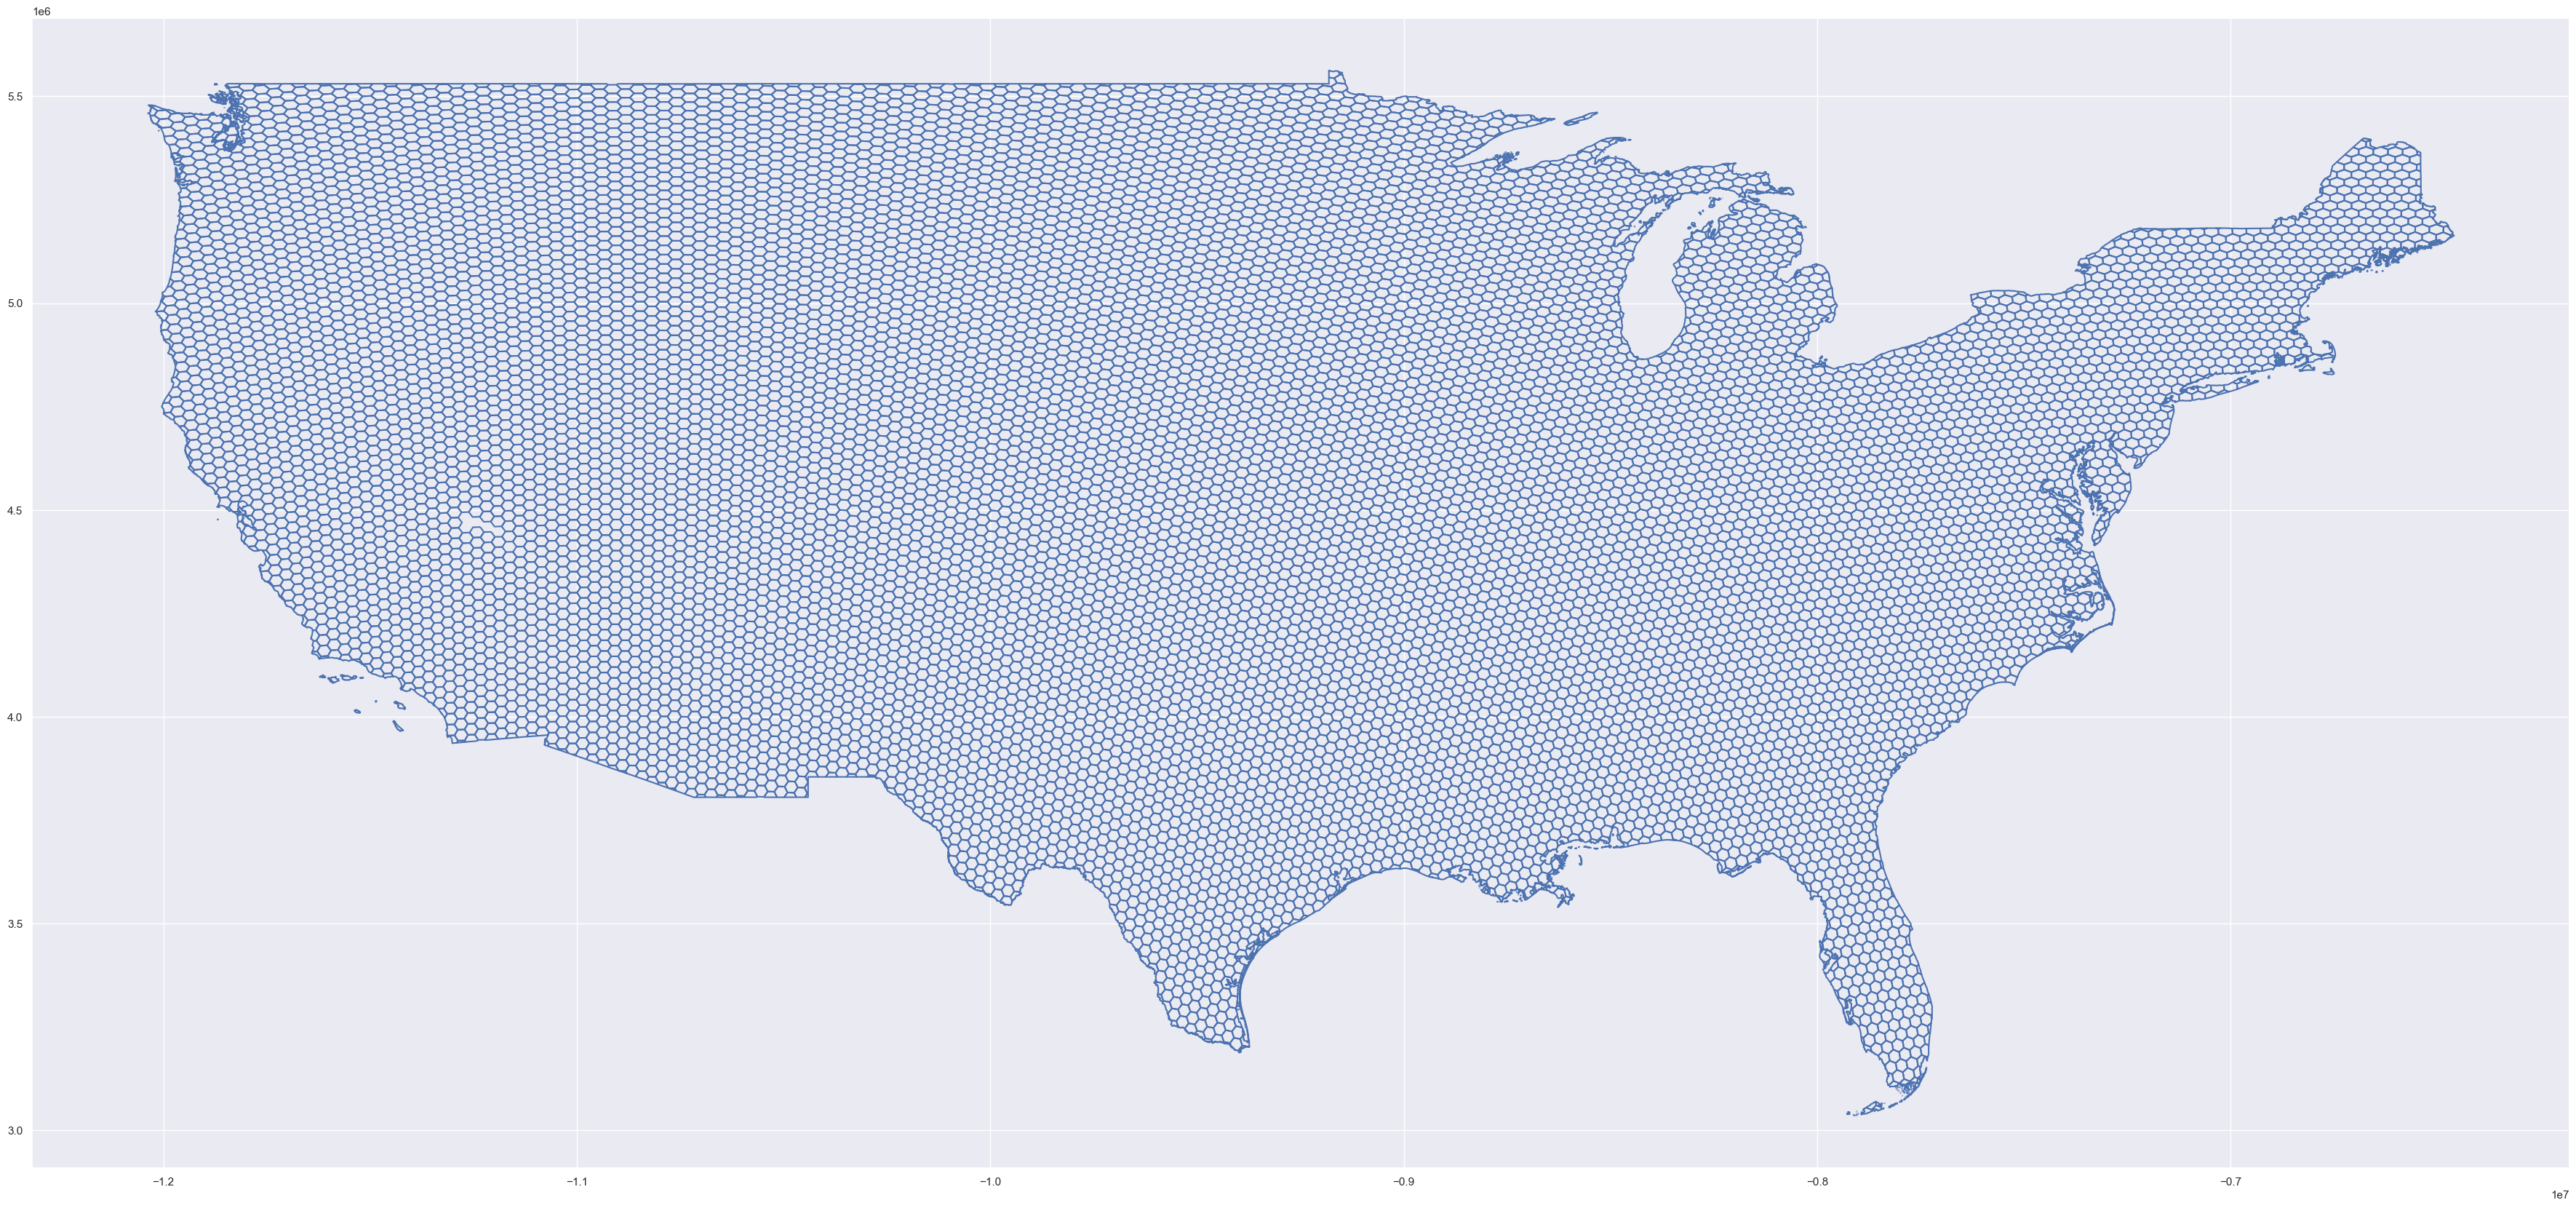

In [3]:
gdf.boundary.plot(figsize=(45, 40))

In [4]:
gdf['lon'] = gdf['geometry'].centroid.x
gdf['lat'] = gdf['geometry'].centroid.y
# gdf['id'] = gdf['id'].astype('int') 
gdf.head()

,EMAP_HEX,area_ha,v0_l4b_mean,v0_l4b_mean_se,fia_mean,fia_mean_se,fia_pf,geometry,lon,lat
0,302.0,3536.497891,44.001065,1.741175,60.357443,0.000000,1.000000,"MULTIPOLYGON (((-6462658.040 5167015.644, -646...",-6.465926e+06,5.162728e+06
1,402.0,31585.418344,66.993306,1.378478,42.720032,14.443391,0.479875,"MULTIPOLYGON (((-6474249.532 5187985.446, -647...",-6.475582e+06,5.175395e+06
2,403.0,56707.037443,62.833595,1.322995,116.444719,11.278149,0.877214,"MULTIPOLYGON (((-6469090.239 5158423.909, -646...",-6.486918e+06,5.159700e+06
3,404.0,14189.174500,70.263095,1.725334,20.461058,13.249689,0.176074,"MULTIPOLYGON (((-6490646.809 5147663.392, -649...",-6.508361e+06,5.145301e+06
4,419.0,2008.140769,64.352575,36.619720,93.476892,0.000000,0.789038,"MULTIPOLYGON (((-6758395.431 4835822.536, -675...",-6.755211e+06,4.836577e+06


In [5]:
# import geopandas as gpd
# from geopandas import GeoDataFrame

# counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
#                                                                             .sort_values(by='id').reset_index(drop=True)

# empty = counties['geometry'].is_empty
# counties_non_empty = counties[~empty]

# counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
# counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
# counties_non_empty['id'] = counties_non_empty['id'].astype('int')
# counties_non_empty.head()

In [6]:
# data = df.merge(counties_non_empty, left_on='GEOID', right_on='id', how='inner')
# data.dropna(inplace=True)
# data.head()

In [7]:
# gdf = GeoDataFrame(data, crs="EPSG:4326")  # change the EPSG, see whether the result changes
# gdf.boundary.plot()

In [32]:
g_y = gdf['fia_mean'].values.reshape((-1,1))
g_X = gdf[['v0_l4b_mean']].values

u = gdf['lon']
v = gdf['lat']

g_coords = list(zip(u,v))

### Calculate LWCC using the Old Algo

In [ ]:
gwr_selector_o = Sel_BW(g_coords, g_y, g_X, lwcc=True, constant=True)
gwr_bw_o = gwr_selector_o.search()
print(gwr_bw_o)
# gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, constant=True, lwcc=False).fit()
# gwr_results_o.summary()

In [ ]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_X, g_y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)  
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]
    
gdf['gwr_calc'] = corr_mat
corr_mat.mean()

In [ ]:
gwr_selector_n = Sel_BW(g_coords, g_y, g_X)
gwr_bw_n = gwr_selector_n.search()
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit()  # using a fixed bandwidth of 200
gwr_results_n.summary()

In [ ]:
gdf['new_algo_params'] = gwr_results_n.params

In [ ]:
from utils import compare_surfaces

In [ ]:
compare_surfaces(gdf, 'new_algo_params', 'gwr_calc', savefig='./figs/use-case 3-hex.png')

In [15]:
corr = []

for i in range(len(g_X)):
    wi = gwr_results_o.model._build_wi(i, gwr_bw_o).reshape(-1,1)
    xw = g_X*wi
    yw = g_y*wi
    corr_coef, _ = stats.pearsonr(xw.flatten(), yw.flatten())
    corr.append(corr_coef)



0.8435077212999303

In [16]:
pd.Series(corr).mean()

0.8435077212999303

In [23]:
pd.Series(corr).isna().any().sum()

1

#### END